# Fine-tuning Embeddings for RAG on Specific Data

As we start our "fine-tuning" week, we'll start with the lowest hanging improvement one can do for RAG - which is:

Fine-tuning embeddings!

- 🤝 Breakout Room #1:
  - Task 1: Dependencies and Boilerplate
  - Task 2: Loading Data
  - Task 3: Constructing a Fine-tuning Dataset
  - Task 4: Fine-tuning `snowflake-arctic-embed-l`
  - Task 5: Evaluating our Retriever



## Task 1: Dependencies and Boilerplate

We'll set up our `nest_asyncio` so we can leverage async loops in our Notebook.

We'll also install the required libraries we'll be using today, and set up our OpenAI API key!

### Nest Asyncio

In [1]:
import nest_asyncio

nest_asyncio.apply()

### Install Dependencies

>> NOTE: You do not need to do these steps if you are running this notebook locally with `uv`.

In [5]:
#!pip install -qU langchain_openai langchain_huggingface langchain_core langchain langchain_community langchain-text-splitters

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/20

In [6]:
 #!pip install -qU faiss-cpu python-pptx==1.0.2 nltk==3.9.1 pymupdf beautifulsoup4 lxml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 11.9 MB/s eta 0:00:00


### Provide OpenAI API Key

In [2]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter Your OpenAI API Key: ")

## Task 2: Loading Data


In [6]:
#!pip install -qU pypdf
# uv add pypdf

In [9]:
from langchain_community.document_loaders import DirectoryLoader, PyPDFLoader

path = "pdf/"
text_loader = DirectoryLoader(path, loader_cls=PyPDFLoader)
docs = text_loader.load()

Next, we'll set up a classic naive chunking strategy as we only care that the documents get parsed into chunks that we can generate synthetic questions about.

In [10]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500, #750
    chunk_overlap  = 50, #20
    length_function = len
)

Next we can load/split these documents as follows.

>> NOTE: You may need to run this cell twice to get it to work.

In [11]:
training_documents = text_splitter.split_documents(text_loader.load())

In [12]:
len(training_documents)

423

Next, we're going to associate each of our chunks with a unique identifier.

In [13]:
import uuid

id_set = set()

for document in training_documents:
  id = str(uuid.uuid4())
  while id in id_set:
    id = uuid.uuid4()
  id_set.add(id)
  document.metadata["id"] = id

Next, we'll simply use naive Python slicing to create a training, test, and validation set to prepare our data for the next step.

In [14]:
training_split_documents = training_documents[:len(training_documents) - 100]
val_split_documents = training_documents[len(training_documents) - 100:423-50]
test_split_documents = training_documents[423-50:]

## Task 3: Constructing a Fine-tuning Dataset

Using the nodes we created above, we can finally start constructing a fine-tuning dataset utilizing OpenAI's `gpt-4o-mini` (released [today](https://openai.com/index/gpt-4o-mini-advancing-cost-efficient-intelligence/)).

The basic idea here is straightforward enough:

1. We look at a document
2. We generate questions that could be answered by that node

This gives us a number of question/context pairs that we can use to fine-tune our Embeddings model.

In [15]:
from langchain_openai import ChatOpenAI

qa_chat_model = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)

We'll create a simple Question Generation prompt to query `gpt-4o-mini` to generate Questions for each retrieved context.

In [16]:
from langchain_core.prompts import ChatPromptTemplate

qa_prompt = """\
Given the following context, you must generate questions based on only the provided context.

You are to generate {n_questions} questions which should be provided in the following format:

1. QUESTION #1
2. QUESTION #2
...

Context:
{context}
"""

qa_prompt_template = ChatPromptTemplate.from_template(qa_prompt)

We'll create a simple chain to query the LLM!

In [17]:
question_generation_chain = qa_prompt_template | qa_chat_model

There's a lot going on in this function - let's take a deeper look:

1. First, we provide a list of documents and a number of questions
2. We, for each document in our list, generate `n_questions` of questions.
3. We then associate those questions and contexts via a `UUID`.

> NOTE: The reason we're doing this `UUID` association is for ease of use later in the notebook.

In [18]:
import tqdm
def create_questions(documents, n_questions):
  questions = {}
  relevant_docs = {}
  for document in tqdm.tqdm(documents):
    document_content = {"context" : document.page_content, "questions" : []}
    questions_generated = question_generation_chain.invoke({"context": document.page_content, "n_questions": n_questions})
    for question in questions_generated.content.split("\n"):
      question_id = str(uuid.uuid4())
      questions[question_id] = "".join(question.split(".")[1:]).strip()
      relevant_docs[question_id] = [document.metadata["id"]]
  return questions, relevant_docs

In [19]:
training_questions, training_relevant_contexts = create_questions(training_split_documents, 2)

  0%|          | 0/323 [00:00<?, ?it/s]

100%|██████████| 323/323 [05:09<00:00,  1.04it/s]


We'll use the function to generate training, validation, and test data.

In [20]:
val_questions, val_relevant_contexts = create_questions(val_split_documents, 2)

100%|██████████| 50/50 [00:50<00:00,  1.01s/it]


In [21]:
test_questions, test_relevant_contexts = create_questions(test_split_documents, 2)

100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


### Reformating and Saving Datasets

Now, we can save our datasets for later use!

In [22]:
import json

training_corpus = {train_item.metadata["id"] : train_item.page_content for train_item in training_split_documents}

train_dataset = {
    "questions" : training_questions,
    "relevant_contexts" : training_relevant_contexts,
    "corpus" : training_corpus
}

with open("training_dataset.jsonl", "w") as f:
  json.dump(train_dataset, f)

In [23]:
val_corpus = {val_item.metadata["id"] : val_item.page_content for val_item in val_split_documents}

val_dataset = {
    "questions" : val_questions,
    "relevant_contexts" : val_relevant_contexts,
    "corpus" : val_corpus
}

with open("val_dataset.jsonl", "w") as f:
  json.dump(val_dataset, f)

In [24]:
train_corpus = {test_item.metadata["id"] : test_item.page_content for test_item in test_split_documents}

test_dataset = {
    "questions" : test_questions,
    "relevant_contexts" : test_relevant_contexts,
    "corpus" : train_corpus
}

with open("test_dataset.jsonl", "w") as f:
  json.dump(test_dataset, f)

## Task 4: Fine-tuning `snowflake-arctic-embed-m`

Now that we have a dataset, let's grab a `sentence-transformers` Embeddings model!

We'll be using Snowflake's [`snowflake-arctic-embed-m`](https://huggingface.co/Snowflake/snowflake-arctic-embed-m) as a base embeddings model.


In [32]:
#!pip install -qU sentence_transformers datasets pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 22.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.12.0 requires pyarrow<19.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 19.0.1 which is incompatible.
pylibcudf-cu12 24.12.0 requires pyarrow<19.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 19.0.1 which is incompatible.


In [25]:
from sentence_transformers import SentenceTransformer

model_id = "Snowflake/snowflake-arctic-embed-m"
model = SentenceTransformer(model_id)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/85.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/107 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/738 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

We'll grab some necessary imports from `sentence_transformers` and `torch`.

> NOTE: PyTorch (`torch`) is a popular machine learning library - while we don't go very deep into PyTorch it's an incredibly powerful and interesting library! Please read more about it [here](https://pytorch.org/tutorials/beginner/basics/intro.html)!

In [26]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sentence_transformers import InputExample

We're using a toy batch size here to reflect the limited number of examples we have.

> NOTE: It is typical to use a much larger batch size (~64+), hardware permitting.

In [27]:
BATCH_SIZE = 10

Let's move our dataset into the expected format for training.

In [28]:
corpus = train_dataset['corpus']
queries = train_dataset['questions']
relevant_docs = train_dataset['relevant_contexts']

examples = []
for query_id, query in queries.items():
    doc_id = relevant_docs[query_id][0]
    text = corpus[doc_id]
    example = InputExample(texts=[query, text])
    examples.append(example)

Now we can create a `torch` `DataLoader`!

In [29]:
loader = DataLoader(
    examples, batch_size=BATCH_SIZE
)

Next up, we'll prepare our loss function!

Loss is an important part of training, fine-tuning, and more. If you want a deep dive on loss - you can check out our [event on loss!](https://www.youtube.com/watch?v=iB8FWR9aD5Q&t=8s).

The core loss we're using today is called `MultipleNegativesRankingLoss` - you can find more information [here](https://github.com/UKPLab/sentence-transformers/blob/master/sentence_transformers/losses/MultipleNegativesRankingLoss.py).

This is "wrapped" in `MatryoshkaLoss`, which you can read the implementation of [here](https://github.com/UKPLab/sentence-transformers/blob/master/sentence_transformers/losses/MatryoshkaLoss.py).

In [30]:
from sentence_transformers.losses import MatryoshkaLoss, MultipleNegativesRankingLoss

matryoshka_dimensions = [768, 512, 256, 128, 64]
inner_train_loss = MultipleNegativesRankingLoss(model)
train_loss = MatryoshkaLoss(
    model, inner_train_loss, matryoshka_dims=matryoshka_dimensions
)

Now we can set-up our evaluator.

> NOTE: Due to the formatting of our dataset - this is all we have to do!

In [31]:
from sentence_transformers.evaluation import InformationRetrievalEvaluator

corpus = val_dataset['corpus']
queries = val_dataset['questions']
relevant_docs = val_dataset['relevant_contexts']

evaluator = InformationRetrievalEvaluator(queries, corpus, relevant_docs)

In [32]:
print(len(val_dataset['questions']))  # Check the number of validation questions

100


We'll train this model for 5 epochs, though you could increase this number if we had a significant amount more data.

In [33]:
EPOCHS = 10

It's training time!

> NOTE: We're manually defining a warm-up period here - this is just to provide a smooth ramp into our training!

In [34]:
import wandb
wandb.init(mode="disabled")

In [35]:
warmup_steps = int(len(loader) * EPOCHS * 0.1)

model.fit(
    train_objectives=[(loader, train_loss)],
    epochs=EPOCHS,
    warmup_steps=warmup_steps,
    output_path='finetuned_arctic_ft',
    show_progress_bar=True,
    evaluator=evaluator,
    evaluation_steps=50
)

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss,Cosine Accuracy@1,Cosine Accuracy@3,Cosine Accuracy@5,Cosine Accuracy@10,Cosine Precision@1,Cosine Precision@3,Cosine Precision@5,Cosine Precision@10,Cosine Recall@1,Cosine Recall@3,Cosine Recall@5,Cosine Recall@10,Cosine Ndcg@10,Cosine Mrr@10,Cosine Map@100
50,No log,No log,0.770000,0.940000,0.970000,0.990000,0.770000,0.313333,0.194000,0.099000,0.770000,0.940000,0.970000,0.990000,0.888551,0.854857,0.855690
65,No log,No log,0.800000,0.910000,0.970000,1.000000,0.800000,0.303333,0.194000,0.100000,0.800000,0.910000,0.970000,1.000000,0.901329,0.869429,0.869429
100,No log,No log,0.800000,0.950000,1.000000,1.000000,0.800000,0.316667,0.200000,0.100000,0.800000,0.950000,1.000000,1.000000,0.909189,0.878667,0.878667
130,No log,No log,0.810000,0.960000,0.990000,1.000000,0.810000,0.320000,0.198000,0.100000,0.810000,0.960000,0.990000,1.000000,0.914575,0.885833,0.885833
150,No log,No log,0.820000,0.960000,0.990000,1.000000,0.820000,0.320000,0.198000,0.100000,0.820000,0.960000,0.990000,1.000000,0.919347,0.892262,0.892262
195,No log,No log,0.800000,0.970000,0.980000,1.000000,0.800000,0.323333,0.196000,0.100000,0.800000,0.970000,0.980000,1.000000,0.909116,0.878750,0.878750
200,No log,No log,0.800000,0.970000,0.980000,1.000000,0.800000,0.323333,0.196000,0.100000,0.800000,0.970000,0.980000,1.000000,0.909295,0.878929,0.878929
250,No log,No log,0.790000,0.970000,0.980000,1.000000,0.790000,0.323333,0.196000,0.100000,0.790000,0.970000,0.980000,1.000000,0.907671,0.876706,0.876706
260,No log,No log,0.790000,0.970000,0.980000,1.000000,0.790000,0.323333,0.196000,0.100000,0.790000,0.970000,0.980000,1.000000,0.905197,0.873512,0.873512
300,No log,No log,0.800000,0.970000,0.980000,1.000000,0.800000,0.323333,0.196000,0.100000,0.800000,0.970000,0.980000,1.000000,0.908888,0.878512,0.878512


In [36]:
from huggingface_hub import notebook_login

notebook_login()

In [37]:
hf_username = "philipk22"

In [59]:
model.push_to_hub(f"{hf_username}/ind312-ft-v0")

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

'https://huggingface.co/philipk22/ind312-ft-v0/commit/9aa76ca50a2e32d8d5be1f1c112962151bebbc67'

## Task 5: Evaluating our Retriever

Now that we have fine-tuned our retriever - let's see if it's worthwhile!

We'll start with some basic imports.

In [38]:
import pandas as pd

from langchain_community.vectorstores import FAISS
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_core.documents import Document

Now we'll define a function that will help us evaluate our retrieval process.

> NOTE: We're assuming 1 correct document in a "hit".

In [39]:
def evaluate_openai(
    dataset,
    embed_model,
    top_k=5,
    verbose=False,
):
  corpus = dataset['corpus']
  questions = dataset['questions']
  relevant_docs = dataset['relevant_contexts']
  documents = [Document(page_content=content, metadata={"id": doc_id}) for doc_id, content in corpus.items()]
  vectorstore = FAISS.from_documents(documents, embed_model)

  retriever = vectorstore.as_retriever(search_kwargs={"k": top_k})

  eval_results = []
  for id, question in tqdm.tqdm(questions.items()):
    retrieved_nodes = retriever.invoke(question)
    retrieved_ids = [node.metadata["id"] for node in retrieved_nodes]
    expected_id = relevant_docs[id][0]
    is_hit = expected_id in retrieved_ids
    eval_results.append({"id": id, "question": question, "expected_id": expected_id, "is_hit": is_hit})

  return eval_results

All that's left to do is evaluate, we'll evaluate our model against:

1. OpenAI's closed source `text-embedding-3-small`
2. The base non-fine-tuned version of `Snowflake/snowflake-arctic-embed-l`.

Let's see how it stacks up!

### `text-embedding-3-small`

In [64]:
te3_openai = OpenAIEmbeddings(model="text-embedding-3-small")
te3_results = evaluate_openai(test_dataset, te3_openai)

100%|██████████| 100/100 [00:38<00:00,  2.58it/s]


In [65]:
te3_results_df = pd.DataFrame(te3_results)

In [66]:
te3_hit_rate = te3_results_df["is_hit"].mean()
te3_hit_rate

0.95

### `Snowflake/snowflake-arctic-embed-m` (base)

In [41]:
from langchain_huggingface import HuggingFaceEmbeddings

huggingface_embeddings = HuggingFaceEmbeddings(model_name="Snowflake/snowflake-arctic-embed-m")
arctic_embed_m_results = evaluate_openai(test_dataset, huggingface_embeddings)

100%|██████████| 100/100 [00:00<00:00, 161.48it/s]


In [43]:
arctic_embed_m_results_df = pd.DataFrame(arctic_embed_m_results)

In [44]:
arctic_embed_m_hit_rate = arctic_embed_m_results_df["is_hit"].mean()
arctic_embed_m_hit_rate

np.float64(0.68)

### `Snowflake/snowflake-arctic-embed-m` (fine-tuned)

In [42]:
finetune_embeddings = HuggingFaceEmbeddings(model_name="philipk22/ind312-ft-v0")
finetune_results = evaluate_openai(test_dataset, finetune_embeddings)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/281 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/26.2k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/675 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at philipk22/ind312-ft-v0 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/1.41k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

100%|██████████| 100/100 [00:00<00:00, 156.21it/s]


In [45]:
finetune_results_df = pd.DataFrame(finetune_results)

In [46]:
finetune_hit_rate = finetune_results_df["is_hit"].mean()
finetune_hit_rate

np.float64(0.99)

## Task 1: Vibe Checking the RAG Pipeline

We're going to use our RAG pipeline to vibe check on some common phrases now that we've modified it!

### Creating New Chunks

In order to try and evaluate our system more fairly, let's create new chunks that we will use to create our Vector Store.

In [47]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500, # 600
    chunk_overlap  = 50,
    length_function = len
)

training_documents = text_splitter.split_documents(text_loader.load())

### Base Chain

We'll start by constructing our base chain, which will use the untrained retrieval model.

#### R - Retrieval

In [48]:
from langchain_community.vectorstores import FAISS

base_vectorstore = FAISS.from_documents(training_documents, huggingface_embeddings)
base_retriever = base_vectorstore.as_retriever(search_kwargs={"k": 6})

#### A - Augmented

In [49]:
from langchain_core.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and a question, you must answer the question. If you do not know the answer, you must state that you do not know.

Context:
{context}

Question:
{question}

Answer:
"""

rag_prompt_template = ChatPromptTemplate.from_template(RAG_PROMPT)

#### G - Generation

In [50]:
rag_llm =  ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)

#### RAG - LCEL RAG Pipeline

In [51]:
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableParallel

base_rag_chain = (
    {"context": itemgetter("question") | base_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt_template | rag_llm | StrOutputParser(), "context": itemgetter("context")}
)

In [52]:
base_rag_chain.invoke({"question" : "What type of studies are required before submitting an IND?"})["response"]

'Before submitting an IND (Investigational New Drug application), sponsors are required to conduct animal toxicology studies or other human studies as appropriate. Additionally, information derived from clinical or epidemiological investigations, animal or in vitro studies, and reports from scientific literature and foreign regulatory authorities may also be necessary.'

In [53]:
base_rag_chain.invoke({"question" : "What happen if the FDA places a clinical hold on an IND application?"})["response"]

'If the FDA places a clinical hold on an IND application, it may do so if it finds that human subjects are or would be exposed to an unreasonable and significant risk of illness or injury, or if the clinical investigators named in the IND are not qualified to conduct the investigation. The affected investigation(s) cannot proceed until the sponsor corrects the deficiencies cited by the FDA or otherwise satisfies the agency that the investigation(s) can proceed. The FDA will notify the sponsor of its determination regarding the clinical hold, and the sponsor may have an opportunity for a regulatory hearing on whether the IND should be reinstated.'

In [54]:
base_rag_chain.invoke({"question" : "what about Compile Drug Substance Information?"})["response"]

'The submission for compiling drug substance information is required to include the following details:\n\n1. A description of the drug substance, including its physical, chemical, or biological characteristics.\n2. The name and address of its manufacturer.\n3. The general method of preparation of the drug substance.\n4. Acceptable limits and analytical methods used to assure the identity, strength, quality, and purity of the drug substance.\n5. Information about both components intended to appear in the drug product and those used in the manufacturing process.\n6. The quantitative composition of the investigational drug product, including any reasonable variations expected during the investigational stage.\n7. The name and address of the drug product manufacturer.\n8. A brief general description of the manufacturing process.'

In [59]:
base_rag_chain.invoke({"question" : "What is the meaning of 'inactive IND' in section 312.45?"})["response"]

'I do not know.'

In [68]:
base_rag_chain.invoke({"question" : "Under section 312.56, what are the situations in which the FDA may suspend an IND?"})["response"]

'I do not know.'

### Fine-tuned Embedding Model

Now let's rebuild our RAG chain with the Fine-tuned model - the only component we need to change is our `FAISS` vectorstore!

In [60]:
finetune_vectorstore = FAISS.from_documents(training_documents, finetune_embeddings)
finetune_retriever = finetune_vectorstore.as_retriever(search_kwargs={"k": 6})

In [61]:
finetune_rag_chain = (
    {"context": itemgetter("question") | finetune_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt_template | rag_llm | StrOutputParser(), "context": itemgetter("context")}
)

In [62]:
finetune_rag_chain.invoke({"question" : "What type of studies are required before submitting an IND?"})["response"]

'The context does not specify the exact type of studies required before submitting an IND (Investigational New Drug application). It mentions that the amount of information submitted in an IND depends on factors such as the novelty of the drug, the extent to which it has been studied previously, and known or suspected risks. However, it does not detail specific study requirements. Therefore, I do not know the answer.'

In [63]:
finetune_rag_chain.invoke({"question" : "What happen if the FDA places a clinical hold on an IND application?"})["response"]

'If the FDA places a clinical hold on an IND application, it issues an order to the sponsor to delay a proposed clinical investigation or to suspend an ongoing investigation. This means that subjects may not be given the investigational drug in a proposed study, and no new subjects may be enrolled in an ongoing study. The clinical hold can apply to one or more investigations covered by the IND.'

In [64]:
finetune_rag_chain.invoke({"question" : "what about Compile Drug Substance Information?"})["response"]

'The context provides information about the requirements for compiling drug substance information in the context of an Investigational New Drug (IND) application. Specifically, it mentions that the submission must include a description of the drug substance, which should cover its physical, chemical, or biological characteristics, the name and address of its manufacturer, the general method of preparation, acceptable limits, and analytical methods used to assure the identity, strength, quality, and purity of the drug substance. Additionally, it should include information about both the components intended to appear in the drug product and those used in the manufacturing process, as well as the quantitative composition of the investigational drug product.'

In [65]:
finetune_rag_chain.invoke({"question" : "What is the meaning of 'inactive IND' in section 312.45?"})["response"]

"An 'inactive IND' refers to an Investigational New Drug application that is not currently active, meaning that the sponsor is not required to submit annual reports for it. However, it remains in effect for the purposes of public disclosure of data and information. An IND can be placed on inactive status by the FDA, particularly if it has been on clinical hold for one year or more, and it may be terminated if it remains inactive for five years or more."

In [67]:
finetune_rag_chain.invoke({"question" : "Under section 312.56, what are the situations in which the FDA may suspend an IND?"})["response"]

'The provided context does not include specific information about section 312.56 or the situations in which the FDA may suspend an IND. Therefore, I do not know the answer to the question.'

## Task 2: RAGAS Evaluation

It's great to have some idea of how our system is doing based on vibe-checks, but let's use RAGAS to provide more insight info. on how things are improving!

> NOTE: Please recreate *exactly* the RAGAS process we used to evaluate RAG, baselining with the default retriever, and then comparing the new retriever. The includes the Synthetic Data Generation steps.

In [69]:
### YOUR CODE Himport os
from getpass import getpass

os.environ["RAGAS_APP_TOKEN"] = getpass("Please enter your Ragas API key!")

In [70]:
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /home/pkang/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/pkang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [71]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

In [72]:
from ragas.testset import TestsetGenerator

docs = training_documents
generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

Applying SummaryExtractor:   0%|          | 0/120 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/423 [00:00<?, ?it/s]

Node 001ef006-1e77-40eb-9b9a-28d5fb115964 does not have a summary. Skipping filtering.
Node c6109735-7ce1-4321-b839-df7cfd8391c9 does not have a summary. Skipping filtering.
Node 0bab2abc-378d-4555-831b-efbc4523fe5f does not have a summary. Skipping filtering.
Node 0e4ae910-66f2-4f7c-b6e8-83c694bea425 does not have a summary. Skipping filtering.
Node f6ae6b5c-bd2d-41d2-aad2-810043a28636 does not have a summary. Skipping filtering.
Node b6e56302-0561-4e89-bb96-6f19c60f977d does not have a summary. Skipping filtering.
Node 59d4a320-1323-4e18-a693-92ba2147f543 does not have a summary. Skipping filtering.
Node 50bbb2c8-12e8-41cb-a711-d7859abf7c89 does not have a summary. Skipping filtering.
Node 1c5a0036-a4dc-402a-ade8-14ed8f289b05 does not have a summary. Skipping filtering.
Node bb6ac2c5-17d6-439c-9a75-d6490844b723 does not have a summary. Skipping filtering.
Node 06e7fa69-6e26-4160-94bf-946d1d6f45ae does not have a summary. Skipping filtering.
Node 53c47780-3ce0-41e6-bc55-b64c461ed8ff d

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/966 [00:00<?, ?it/s]

Applying OverlapScoreBuilder:   0%|          | 0/1 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/10 [00:00<?, ?it/s]

In [73]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,What role does the Department of Health and Hu...,[Title 21 —Food and Drugs\nChapter I —Food and...,"The Department of Health and Human Services, t...",single_hop_specifc_query_synthesizer
1,"What all the things you gotta do for IND, like...",[§ 312.10 Waivers.\nSubpart B Investigational ...,The IND process involves several steps and req...,single_hop_specifc_query_synthesizer
2,Could you elaborate on the role of the eCFR in...,[§ 312.53 Selecting investigators and monitors...,"The eCFR, while authoritative but unofficial, ...",single_hop_specifc_query_synthesizer
3,What FDA do with drugs for life-threatening il...,[§ 312.69 Handling of controlled substances.\n...,The FDA conducts a risk-benefit analysis in th...,single_hop_specifc_query_synthesizer
4,What are the key responsibilities of the FDA i...,[§ 312.86 Focused FDA regulatory research.\n§ ...,The FDA's key responsibilities in the context ...,single_hop_specifc_query_synthesizer
5,What are the requirements under 21 CFR 312.23(...,"[<1-hop>\n\nStates or other countries, detaile...","Under 21 CFR 312.23(a)(9)(i), investigational ...",multi_hop_specific_query_synthesizer
6,How do the regulations outlined in 21 CFR 312....,[<1-hop>\n\n(c) Safeguard. The sponsor is resp...,The regulations outlined in 21 CFR 312.70(b) e...,multi_hop_specific_query_synthesizer
7,What are the regulatory requirements outlined ...,[<1-hop>\n\n(b) A sponsor shall not begin a cl...,"According to 21 CFR 312.20(b), a sponsor is pr...",multi_hop_specific_query_synthesizer
8,What is the relationship between 21 CFR 312.3 ...,[<1-hop>\n\n21 CFR 312.3 “FDA” (enhanced displ...,21 CFR 312.3 provides definitions and general ...,multi_hop_specific_query_synthesizer
9,How do the regulations outlined in 21 CFR 312....,[<1-hop>\n\nimmediate hazards to the human sub...,The regulations outlined in 21 CFR 312.53(c)(1...,multi_hop_specific_query_synthesizer


In [74]:

dataset.upload()

Testset uploaded! View at https://app.ragas.io/dashboard/alignment/testset/9e6a6640-9fd6-46cb-bf65-1a8eaf77e451


'https://app.ragas.io/dashboard/alignment/testset/9e6a6640-9fd6-46cb-bf65-1a8eaf77e451'

## Evaluating the App with Ragas

In [75]:
for test_row in dataset:
  response = base_rag_chain.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"]
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

In [76]:
dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,What role does the Department of Health and Hu...,"[(e) Guidance. FDA may, on its own initiative,...",[Title 21 —Food and Drugs\nChapter I —Food and...,I do not know.,"The Department of Health and Human Services, t...",single_hop_specifc_query_synthesizer
1,"What all the things you gotta do for IND, like...",[replies to inquiries. Further details on this...,[§ 312.10 Waivers.\nSubpart B Investigational ...,The Investigational New Drug (IND) application...,The IND process involves several steps and req...,single_hop_specifc_query_synthesizer
2,Could you elaborate on the role of the eCFR in...,[replies to inquiries. Further details on this...,[§ 312.53 Selecting investigators and monitors...,I do not know.,"The eCFR, while authoritative but unofficial, ...",single_hop_specifc_query_synthesizer
3,What FDA do with drugs for life-threatening il...,[Administration (FDA) has determined that it i...,[§ 312.69 Handling of controlled substances.\n...,The FDA provides its best judgment regarding t...,The FDA conducts a risk-benefit analysis in th...,single_hop_specifc_query_synthesizer
4,What are the key responsibilities of the FDA i...,[request a meeting with FDA-reviewing official...,[§ 312.86 Focused FDA regulatory research.\n§ ...,The key responsibilities of the FDA in the con...,The FDA's key responsibilities in the context ...,single_hop_specifc_query_synthesizer
5,What are the requirements under 21 CFR 312.23(...,[compliance with the applicable provisions of ...,"[<1-hop>\n\nStates or other countries, detaile...",I do not know the specific requirements under ...,"Under 21 CFR 312.23(a)(9)(i), investigational ...",multi_hop_specific_query_synthesizer
6,How do the regulations outlined in 21 CFR 312....,[compliance with the applicable provisions of ...,[<1-hop>\n\n(c) Safeguard. The sponsor is resp...,I do not know.,The regulations outlined in 21 CFR 312.70(b) e...,multi_hop_specific_query_synthesizer
7,What are the regulatory requirements outlined ...,[21 CFR 312.3 “FDA” (enhanced display) page 4 ...,[<1-hop>\n\n(b) A sponsor shall not begin a cl...,I do not know.,"According to 21 CFR 312.20(b), a sponsor is pr...",multi_hop_specific_query_synthesizer
8,What is the relationship between 21 CFR 312.3 ...,[the study.\n21 CFR Part 312 (up to date as of...,[<1-hop>\n\n21 CFR 312.3 “FDA” (enhanced displ...,I do not know.,21 CFR 312.3 provides definitions and general ...,multi_hop_specific_query_synthesizer
9,How do the regulations outlined in 21 CFR 312....,[between FDA and the sponsor of the overall pl...,[<1-hop>\n\nimmediate hazards to the human sub...,I do not know.,The regulations outlined in 21 CFR 312.53(c)(1...,multi_hop_specific_query_synthesizer


In [77]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

In [78]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))

In [80]:
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity, ContextPrecision
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity(), ContextPrecision()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/70 [00:00<?, ?it/s]

Exception raised in Job[51]: TypeError(ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'')
Exception raised in Job[58]: TypeError(ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'')
Exception raised in Job[12]: TimeoutError()


{'context_recall': 0.0750, 'faithfulness': 0.2897, 'factual_correctness': 0.0612, 'answer_relevancy': 0.2811, 'context_entity_recall': 0.1352, 'noise_sensitivity_relevant': 0.1111, 'context_precision': 0.1000}

## Test with fine-tuned embedding model

In [81]:
for test_row in dataset:
  
  response = finetune_rag_chain.invoke({"question" : test_row.eval_sample.user_input})

  test_row.eval_sample.response = response["response"]
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

In [82]:
dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,What role does the Department of Health and Hu...,[Title 21 —Food and Drugs\nChapter I —Food and...,[Title 21 —Food and Drugs\nChapter I —Food and...,The Department of Health and Human Services (H...,"The Department of Health and Human Services, t...",single_hop_specifc_query_synthesizer
1,"What all the things you gotta do for IND, like...",[§ 312.10 Waivers.\nSubpart B Investigational ...,[§ 312.10 Waivers.\nSubpart B Investigational ...,For an Investigational New Drug (IND) applicat...,The IND process involves several steps and req...,single_hop_specifc_query_synthesizer
2,Could you elaborate on the role of the eCFR in...,[§ 312.53 Selecting investigators and monitors...,[§ 312.53 Selecting investigators and monitors...,The eCFR (Electronic Code of Federal Regulatio...,"The eCFR, while authoritative but unofficial, ...",single_hop_specifc_query_synthesizer
3,What FDA do with drugs for life-threatening il...,[drug in pediatric patients. For drugs for lif...,[§ 312.69 Handling of controlled substances.\n...,The FDA provides its best judgment regarding d...,The FDA conducts a risk-benefit analysis in th...,single_hop_specifc_query_synthesizer
4,What are the key responsibilities of the FDA i...,[longer period of time.\n§ 312.86 Focused FDA ...,[§ 312.86 Focused FDA regulatory research.\n§ ...,The key responsibilities of the FDA in the con...,The FDA's key responsibilities in the context ...,single_hop_specifc_query_synthesizer
5,What are the requirements under 21 CFR 312.23(...,[the study.\n21 CFR Part 312 (up to date as of...,"[<1-hop>\n\nStates or other countries, detaile...",I do not know.,"Under 21 CFR 312.23(a)(9)(i), investigational ...",multi_hop_specific_query_synthesizer
6,How do the regulations outlined in 21 CFR 312....,[compliance with the applicable provisions of ...,[<1-hop>\n\n(c) Safeguard. The sponsor is resp...,I do not know.,The regulations outlined in 21 CFR 312.70(b) e...,multi_hop_specific_query_synthesizer
7,What are the regulatory requirements outlined ...,[ongoing clinical investigations or response t...,[<1-hop>\n\n(b) A sponsor shall not begin a cl...,The regulatory requirements outlined in 21 CFR...,"According to 21 CFR 312.20(b), a sponsor is pr...",multi_hop_specific_query_synthesizer
8,What is the relationship between 21 CFR 312.3 ...,[the study.\n21 CFR Part 312 (up to date as of...,[<1-hop>\n\n21 CFR 312.3 “FDA” (enhanced displ...,I do not know.,21 CFR 312.3 provides definitions and general ...,multi_hop_specific_query_synthesizer
9,How do the regulations outlined in 21 CFR 312....,[immediate hazards to the human subjects.\n21 ...,[<1-hop>\n\nimmediate hazards to the human sub...,I do not know.,The regulations outlined in 21 CFR 312.53(c)(1...,multi_hop_specific_query_synthesizer


In [83]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

In [85]:
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity, ContextPrecision
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity(), ContextPrecision()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/70 [00:00<?, ?it/s]

Exception raised in Job[12]: TimeoutError()
Exception raised in Job[33]: TimeoutError()


{'context_recall': 0.4000, 'faithfulness': 0.3814, 'factual_correctness': 0.1460, 'answer_relevancy': 0.5615, 'context_entity_recall': 0.2310, 'noise_sensitivity_relevant': 0.1680, 'context_precision': 0.3167}

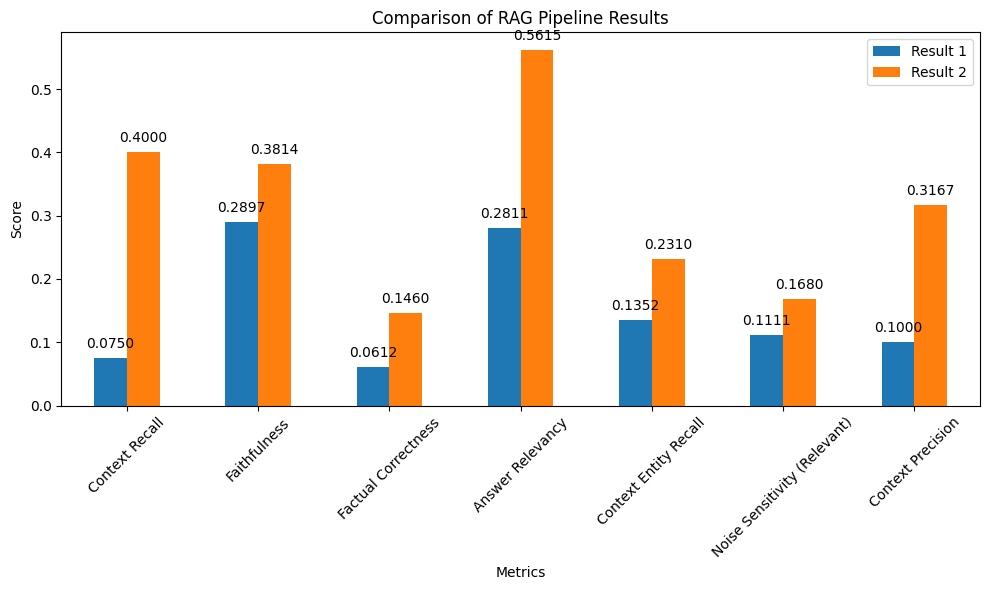

In [86]:
import pandas as pd
import matplotlib.pyplot as plt

# Data
data = {
    'Metric': ['Context Recall', 'Faithfulness', 'Factual Correctness', 'Answer Relevancy', 'Context Entity Recall', 'Noise Sensitivity (Relevant)', 'Context Precision'],
    'Result 1': [0.0750, 0.2897, 0.0612, 0.2811, 0.1352, 0.1111, 0.1000],
    'Result 2': [0.4000, 0.3814, 0.1460, 0.5615, 0.2310, 0.1680, 0.3167]
}

df = pd.DataFrame(data)
df = df.set_index('Metric')

# Plotting
ax = df.plot(kind='bar', figsize=(10, 6), rot=45)

# Add labels and title
plt.title('Comparison of RAG Pipeline Results')
plt.xlabel('Metrics')
plt.ylabel('Score')

# Add value labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Show the plot
plt.tight_layout()
plt.show()